In [11]:
#pip install pmdarima

# State Space Model Using ARIMA Method

[10 year US Government Bond Yields (long-term interest rate)](https://datahub.io/core/bond-yields-us-10y#readme)
***

### Steps for ARIMA implementation

- **Load the data**: The first step for model building is of course to load the dataset
- **Preprocessing**: Depending on the dataset, the steps of preprocessing will be defined. This will include creating timestamps, converting the dtype of date/time column, making the series univariate, etc.
- **Make series stationary**: In order to satisfy the assumption, it is necessary to make the series stationary. This would include checking the stationarity of the series and performing required transformations
- **Determine d value**: For making the series stationary, the number of times the difference operation was performed will be taken as the d value
- **Create ACF and PACF plots**: This is the most important step in ARIMA implementation. ACF PACF plots are used to determine the input parameters for our ARIMA model
- **Determine the p and q values**: Read the values of p and q from the plots in the previous step
- **Fit ARIMA model**: Using the processed data and parameter values we calculated from the previous steps, fit the ARIMA model
- **Predict values on validation set**: Predict the future values
- **Calculate RMSE**: To check the performance of the model, check the RMSE value using the predictions and actual values on the validation set
***

# Load the Data

We will include Statsmodels into our workflow which we will use specifically for its powerful TSA models.

In [12]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import kpss

import scipy
from scipy.stats import pearsonr

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

#matplotlib.rcParams['figure.figsize'] = [8, 3]
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#from matplotlib import rcParams
#from cycler import cycler

#rcParams['figure.figsize'] = 18, 5
#rcParams['axes.spines.top'] = True
#rcParams['axes.spines.right'] = True
#rcParams['axes.prop_cycle'] = cycler(color=['#365977'])
#rcParams['lines.linewidth'] = 2.5

print('Matplotlib:',matplotlib.__version__)
print('Pandas:',pd.__version__)
print('Numpy:',np.__version__)
print('StatsModel:',statsmodels.__version__)
print('Scipy:',scipy.__version__)

Matplotlib: 3.3.2
Pandas: 1.1.3
Numpy: 1.23.0
StatsModel: 0.12.2
Scipy: 1.5.2



# Preprocessing Data

Within reading in our dataframe we can include our datetime and index functions upon our univariate data. 


In [13]:
# Read in data
month = pd.read_excel('/Users/jasonrobinson/Documents/Projects/time_series_analysis/data/U.S. 10-yr-Bond.xls', parse_dates=['Date'], index_col='Date')
print(month.shape)
month.head()

(808, 1)


,Rate
Date,
1953-04-30,2.83
1953-05-31,3.05
1953-06-30,3.11
1953-07-31,2.93
1953-08-31,2.95



### Visualize our data

For the entire range we see an upward and downward non-stationary trend.

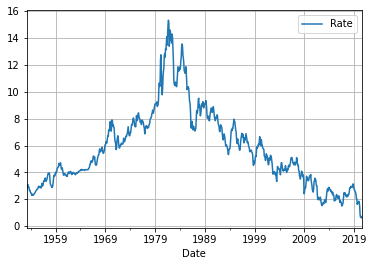

In [15]:
month.plot(grid=True);


### Seasonal decomposition

Seasonal decomposition

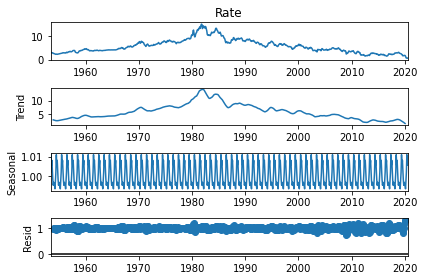

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(month['Rate'], model="multiplicative")
decompose_data.plot();

In [17]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(month['Rate'], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -0.8608812083947054
2. P-Value :  0.8005817806678095
3. Num Of Lags :  21
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 786
5. Critical Values :
	 1% :  -3.438697054464251
	 5% :  -2.8652241623148678
	 10% :  -2.5687317987167284


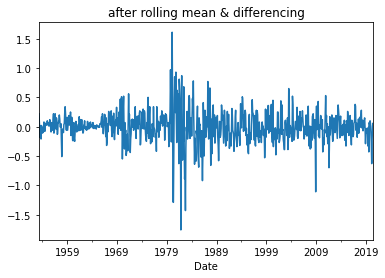

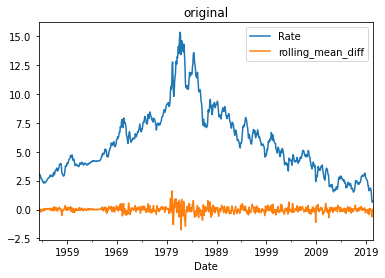

In [19]:
rolling_mean = month['Rate'].rolling(window = 1).mean()
month['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
month['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
month.plot(title='original');

In [27]:
dftest = adfuller(month['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -6.945198507932591
2. P-Value :  1.0013681038601904e-09
3. Num Of Lags :  21
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 785
5. Critical Values :
	 1% :  -3.438707722728768
	 5% :  -2.8652288644673125
	 10% :  -2.568734303622865


In [50]:
#month_arima = month['rolling_mean_diff'].dropna()
#month = month_arima.round(4)

In [51]:
#month[month.index>'2018'].head()

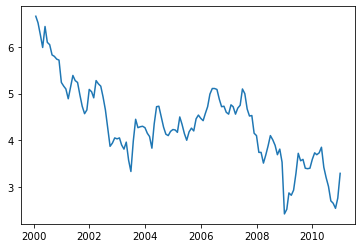

In [20]:
# 10-year period (2000-2010)
plt.plot(month['2000':'2010']['Rate']);

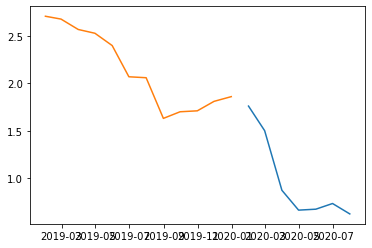

In [21]:
# 10-year period (2010-2020)
plt.plot(month['2020':'2020']['Rate']);
plt.plot(month['2019':'2019']['Rate']);
#plt.plot(month['2018':'2018']['Rate']);
#plt.plot(month['2017':'2017']['Rate']);
#plt.plot(month['2016':'2016']['Rate']);
#plt.plot(month['2015':'2015']['Rate']);

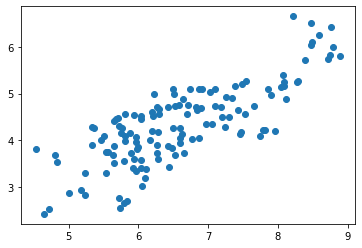

In [22]:
# Comparing 2 previous decades
plt.scatter(month['1990':'2000'][['Rate']], month['2000':'2010'][['Rate']]);

In [23]:
month['1990':'2000'][['Rate']].head()

,Rate
Date,
1990-01-31,8.21
1990-02-28,8.47
1990-03-31,8.59
1990-04-30,8.79
1990-05-31,8.76


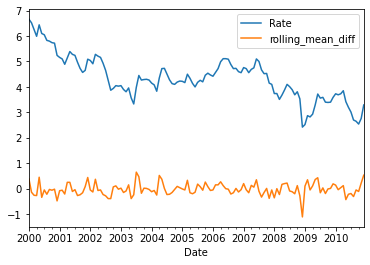

In [24]:
month['2000':'2010'].plot();

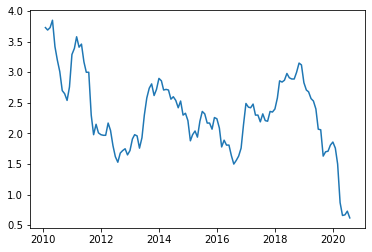

In [25]:
plt.plot(month['2010':'2020'][['Rate']]);

In [34]:
month = month[month['rolling_mean_diff']<=1953-4-30]
month

,Rate,rolling_mean_diff
Date,,
1953-05-31,3.05,0.22
1953-06-30,3.11,0.06
1953-07-31,2.93,-0.18
1953-08-31,2.95,0.02
1953-09-30,2.87,-0.08
...,...,...
2020-03-31,0.87,-0.63
2020-04-30,0.66,-0.21
2020-05-31,0.67,0.01



### Test for Stationarity

To be capable of applying an **ARIMA** method, we will first need to add stationarity. First let's confirm that our time series is not stationary. A few methods exist for this, but we will use the **KPSS** method.



In [37]:
from pmdarima.arima import ADFTest
# Augmented Dickey-Fuller test

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(month['rolling_mean_diff'])

(0.01, False)

In [38]:
from statsmodels.tsa.stattools import adfuller


def adf_test(month):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(month['rolling_mean_diff'], autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    

    
adf_test(month)

Results of Dickey-Fuller Test:
Test Statistic                -6.945199e+00
p-value                        1.001368e-09
#Lags Used                     2.100000e+01
Number of Observations Used    7.850000e+02
Critical Value (1%)           -3.438708e+00
Critical Value (5%)           -2.865229e+00
Critical Value (10%)          -2.568734e+00
dtype: float64


In [39]:
from statsmodels.tsa.stattools import kpss


def kpss_test(month):
    print("Results of KPSS Test:")
    kpsstest = kpss(month["rolling_mean_diff"], regression="ct", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
    
    
    
kpss_test(month)

Results of KPSS Test:
Test Statistic           0.048993
p-value                  0.100000
Lags Used                0.000000
Critical Value (10%)     0.119000
Critical Value (5%)      0.146000
Critical Value (2.5%)    0.176000
Critical Value (1%)      0.216000
dtype: float64


In [63]:
# Reject the null hypothesis - test statistic actual pvalue smaller
#sm.tsa.stattools.kpss(month, regression='ct')

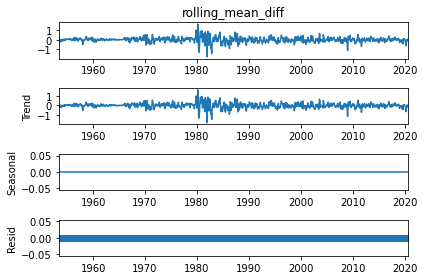

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose

seas_dcomp = seasonal_decompose(month['rolling_mean_diff'],period=1,model='additive')
seas_dcomp.plot();

# Run all the above and begin from here
###  Make Series Stationary


In [65]:
#Transform the data from non-statinary to stationary
month_log = np.sqrt(month['Rate'])
month_diff = month_log.diff().dropna()

In [66]:
month_diff

Date
1953-05-31    0.064165
1953-06-30    0.017094
1953-07-31   -0.051795
1953-08-31    0.005832
1953-09-30   -0.023449
                ...   
2020-03-31   -0.292007
2020-04-30   -0.120334
2020-05-31    0.006131
2020-06-30    0.035865
2020-07-31   -0.067000
Name: Rate, Length: 807, dtype: float64

In [67]:
# Check for stationarity
result = adfuller(month_diff)
print('Test Statistic: %f' %result[0])
print('p-value: %f' %result[1])
print('Critical values:')
for key, value in result[4].items ():
     print('\t%s: %.3f' %(key, value))

Test Statistic: -14.931696
p-value: 0.000000
Critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [68]:
result_kpss_ct_log=kpss(month_diff,regression="ct")
print('Test Statistic: %f' % np.round(result_kpss_ct_log[0],2))
print('p-value: %f' %result_kpss_ct_log[1])
print('Critical values:')
for key, value in result_kpss_ct_log[3].items():
     print('\t%s: %.3f' %(key, value))

Test Statistic: 0.030000
p-value: 0.100000
Critical values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


In [69]:
#month_new = month['Rate']
#month_24 = month_new[777:-7]
#month_24.shape

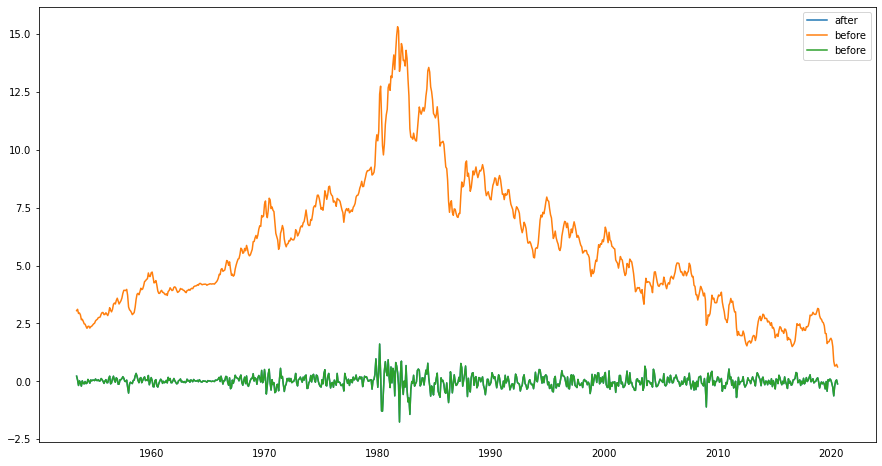

In [44]:
# Before and After confirmation
plt.figure(figsize=(15,8))
plt.plot(month['rolling_mean_diff'],label="after")
plt.plot(month,label="before")
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.legend()
plt.show()

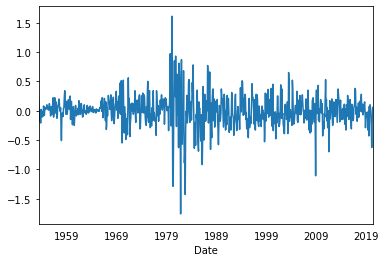

In [45]:
# Closer display
month['rolling_mean_diff'].plot()
plt.tick_params(
    axis='x',        
    which='both',
    color='orange',
    bottom=False,      
    top=False,        
    labelbottom=True)
plt.show();


### ACF/PACF

We can use these two functions to allow us to see at which level of lag is most significant towards the current value.


In [ ]:
# First order 
#month['Rate_diff'] = month['Rate'].diff(periods=12)
#month['Rate'] = month.dropna()

In [46]:
# Autocorrelation
acf_month = acf(month['rolling_mean_diff'])
acf_month

array([ 1.        ,  0.30500626, -0.09434786, -0.03211459,  0.00290139,
        0.05463554, -0.03845274, -0.08936423,  0.04034791,  0.0626902 ,
        0.06874189,  0.08883969, -0.03428228, -0.05465328, -0.04500505,
       -0.10684896, -0.04937093, -0.03175326,  0.01997035,  0.01710165,
       -0.08107014, -0.12965541,  0.01050919,  0.04781104, -0.02984551,
       -0.0671926 ,  0.00262825,  0.02797874,  0.01949173,  0.01850709,
       -0.00940499, -0.02822614, -0.00713074,  0.0692374 ,  0.03304117,
        0.00858911,  0.01488539, -0.02387624,  0.00481996,  0.02144604,
       -0.00190455])

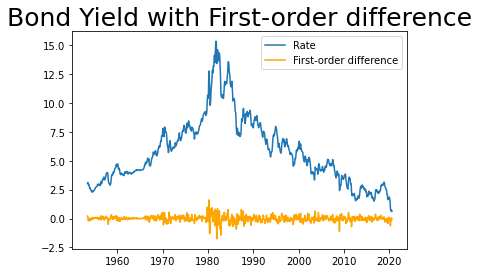

In [47]:
# Visualize our plots
plt.title('Bond Yield with First-order difference', size=25)
plt.plot(month['Rate'], label='Rate')
plt.plot(month['rolling_mean_diff'], label='First-order difference', color='orange')
plt.legend();

Nice, we can definitely tell the difference, but let's see if we can do better

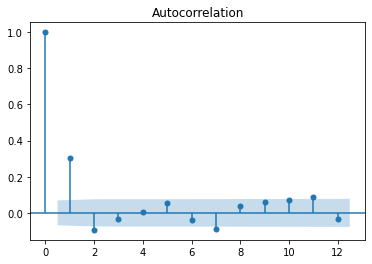

In [48]:
plot_acf(month['rolling_mean_diff'], lags=12);

Most important is 1

In [49]:
# Partial autocorrelation
pacf_month = pacf(month['rolling_mean_diff'])
pacf_month.round(2)

array([ 1.  ,  0.31, -0.21,  0.08, -0.03,  0.08, -0.1 , -0.03,  0.08,
        0.  ,  0.07,  0.06, -0.08, -0.01, -0.05, -0.09,  0.  , -0.04,
        0.05, -0.05, -0.07, -0.11,  0.07,  0.  , -0.03, -0.02,  0.05,
       -0.05,  0.02,  0.03, -0.02, -0.01,  0.01,  0.07, -0.04,  0.04,
       -0.02, -0.04,  0.02,  0.02, -0.02])

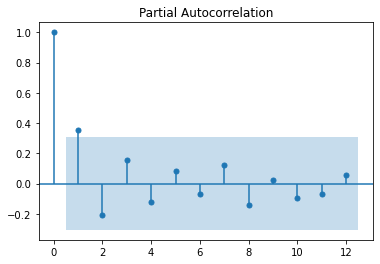

In [76]:
plot_pacf(pacf_month, lags=12);

In [51]:
month['rolling_mean_diff'].isnull().sum()

0


## Auto-ARIMA

In [ ]:
#pd.options.display.max_rows=None
#month['rolling_mean_diff'] = month['rolling_mean_diff'].dropna(inplace=False)
#month['rolling_mean_diff']

In [53]:
from pmdarima import auto_arima

month_fit = auto_arima(month['rolling_mean_diff'],start_p=0, d=1, start_q=0, 
                          max_p=3, max_d=3, max_q=3, start_P=0, 
                          D=1, start_Q=0, max_P=3, max_D=3,
                          max_Q=3, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=42,n_fits = 50 )

print(month_fit.summary().tables[1])

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1023.843, Time=2.43 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=743.193, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.57 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=981.215, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=629.101, Time=0.78 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=585.056, Time=1.46 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=9.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=5.69 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=611.397, Time=1.02 sec
 ARIMA(2,1,0)(3,1,0)[12]             : AIC=442.945, Time=1.66 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=485.400, Time=0.93 sec
 ARIMA(2,1,0)(3,1,1)[12]             : AIC=inf, Time=9.95 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=7.03 sec
 ARIMA(3,1,0)(3,1,0)[12]             : AIC=412.277, Time=2.06 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=452.661, 

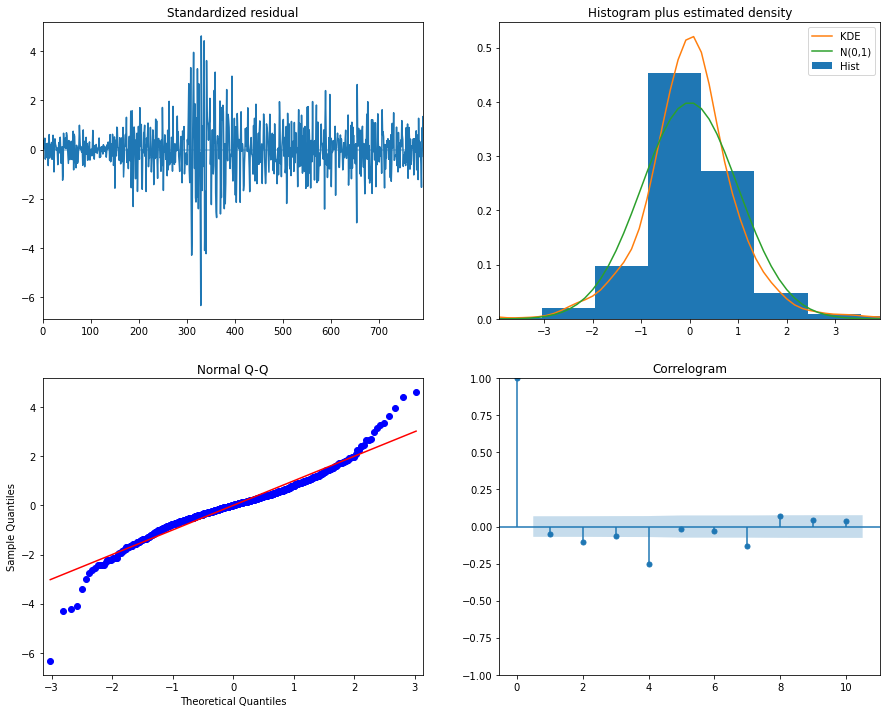

In [54]:
month_fit.plot_diagnostics(figsize=(15, 12))
plt.show();


## SARIMAX

Using the SARIMAX model we will incorporate two orders. The first-order is p,d,q and the other is P,D,Q,m to accountfor seasonality.

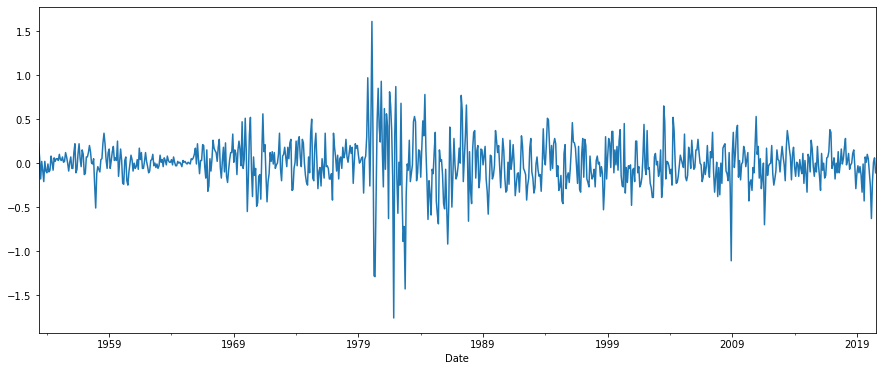

In [84]:
month['rolling_mean_diff'].plot(figsize=(15, 6))
plt.show()

In [59]:
train = month['rolling_mean_diff'].iloc[:len(month['rolling_mean_diff'])-12]
test = month['rolling_mean_diff'].iloc[len(month['rolling_mean_diff'])-12:]
test.index, train

(DatetimeIndex(['2019-08-31', '2019-09-30', '2019-10-31', '2019-11-30',
                '2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
                '2020-04-30', '2020-05-31', '2020-06-30', '2020-07-31'],
               dtype='datetime64[ns]', name='Date', freq=None),
 Date
 1953-05-31    0.22
 1953-06-30    0.06
 1953-07-31   -0.18
 1953-08-31    0.02
 1953-09-30   -0.08
               ... 
 2019-03-31   -0.11
 2019-04-30   -0.04
 2019-05-31   -0.13
 2019-06-30   -0.33
 2019-07-31   -0.01
 Name: rolling_mean_diff, Length: 795, dtype: float64)

In [68]:
# Split data into train / test sets
train = month['Rate'].iloc[:len(month['Rate'])-12]
test = month['Rate'].iloc[len(month['Rate'])-12:] # set one year(12 months) for testing
  
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train, 
                order = (2, 1, 1), 
                seasonal_order =(2, 1, 1, 12))
  
result = model.fit()
result.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04432D-01    |proj g|=  1.08090D+00

At iterate    5    f=  1.46807D-01    |proj g|=  1.61972D-01

At iterate   10    f=  9.45784D-02    |proj g|=  2.49722D-01

At iterate   15    f=  5.31651D-02    |proj g|=  4.15466D-02

At iterate   20    f=  4.65236D-02    |proj g|=  4.43015D-03

At iterate   25    f=  4.59042D-02    |proj g|=  1.15511D-02

At iterate   30    f=  4.58638D-02    |proj g|=  6.97920D-04

At iterate   35    f=  4.58546D-02    |proj g|=  5.77267D-03

At iterate   40    f=  4.58476D-02    |proj g|=  9.13301D-04

At iterate   45    f=  4.58435D-02    |proj g|=  9.98557D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               Rate   No. Observations:                  795
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 -36.445
Date:                            Sat, 23 Jul 2022   AIC                             86.891
Time:                                    17:57:27   BIC                            119.524
Sample:                                05-31-1953   HQIC                            99.440
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1124      0.069     -1.636      0.102      -0.247       0.022
ar.L2         -0.0594      0.036     -1.658      0.097      -0.130       0.011
ma.L1          0.5122      0.070      7.319      0.000       0.375       0.649
ar.S.L12      -0.0551      0.027     -2.049      0.040      -0.108      -0.002
ar.S.L24      -0.0203      0.036     -0.564      0.573      -0.091       0.050
ma.S.L12      -0.9966      0.167     -5.950      0.000      -1.325      -0.668
sigma2         0.0602      0.010      6.192      0.000       0.041       0.079
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1004.10
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
pred = result.get_prediction(start='2019-08-31', dynamic=False)
pred_ci = pred.conf_int()

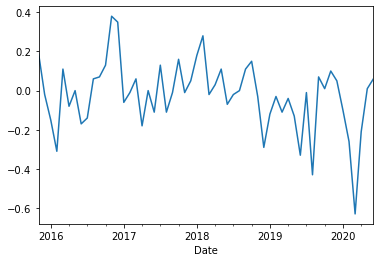

In [114]:
month['rolling_mean_diff'][750:-1].plot();

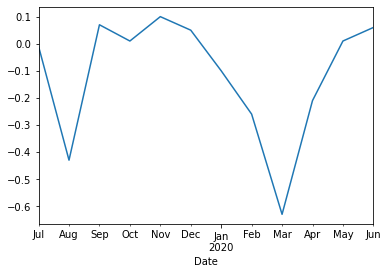

In [117]:
# Rises every 6 months (seasonal)
month['rolling_mean_diff'][794:-1].plot();

In [119]:
ax = result.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Rate')
plt.legend()

plt.show()

AttributeError: 'SARIMAXResults' object has no attribute 'plot'

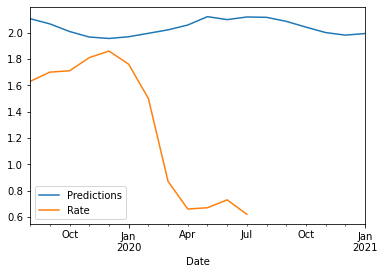

In [79]:
start = len(train)
end = len(train) + len(test) + 5
  
# Predictions for one-year against the test set
predictions = result.predict(start, end,
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True);
test.plot(legend = True);

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

rmse(test, predictions)
mean_squared_error(test, predictions)

In [ ]:
# Train the model on the full dataset
model = model = SARIMAX(month_diff, 
                        order = (0, 1, 1), 
                        seasonal_order =(2, 1, 1, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(month_diff), 
                          end = (len(month_diff)-1) + 3 * 3
                          , 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
month_diff.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);



### Alternate version


In [ ]:
mod = sm.tsa.statespace.SARIMAX(month['Rate'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

In [ ]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()
predict_ci

Clearly we see that the model is not predicting well according to our predictions. However, an attempt will be made to determine if parameter tuning would extend the results that we desire.